In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [ ]:
!mkdir plant_diseases

In [ ]:
!unzip /content/archive.zip -d /content/archive/

Archive:  /content/archive.zip
   creating: /content/archive/bacterial/
  inflating: /content/archive/bacterial/bacterial_0_1813.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_187.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_1891.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_1927.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_2632.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_2653.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3039.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3187.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_319.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3295.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3443.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3457.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3523.jpeg  
  inflating: /content/archive/bacterial/bacterial_0_3529.jpeg  
  inflating: /content/archive/bact

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/archive",
    labels="inferred",  # Automatically infer labels from subdirectory names
    label_mode="int",   # Labels should be integers
    color_mode="rgb",   # Assuming RGB images
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,       # Shuffle the dataset
)


Found 2343 files belonging to 6 classes.


In [ ]:
#display dataset classes
class_names = dataset.class_names
class_names

['bacterial', 'diseased', 'fungal', 'healthy', 'healthy_plants', 'pests']

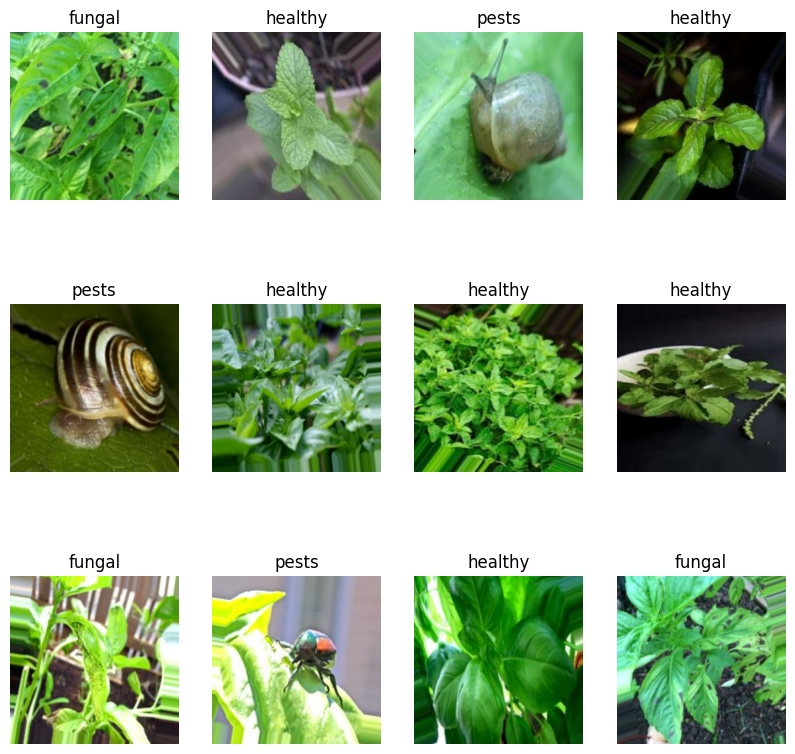

In [ ]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

74

In [ ]:
#train dataset length calculation
train_size = 0.8
len(dataset)*train_size

59.2

In [ ]:
train_ds = dataset.take(57)
len(train_ds)

57

In [ ]:
#test dataset lenght calculation
test_ds = dataset.skip(57)
len(test_ds)

17

In [ ]:
#validation dataset length calculation
val_size=0.1
len(dataset)*val_size

7.4

In [ ]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [ ]:
test_ds = test_ds.skip(7)
len(test_ds)

10

In [ ]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(dataset)

74

In [ ]:
len(train_ds)


59

In [ ]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#pre-processing: image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))


In [ ]:
for images, labels in normalized_dataset:
    for image in images:
        print(image)

Streaming output truncated to the last 5000 lines.
tf.Tensor(
[[[0.227451   0.45882356 0.85098046]
  [0.227451   0.45882356 0.85098046]
  [0.22475491 0.46421573 0.8536765 ]
  ...
  [0.19632354 0.47328433 0.85759807]
  [0.18823531 0.47058827 0.854902  ]
  [0.18823531 0.47058827 0.854902  ]]

 [[0.23382354 0.4651961  0.857353  ]
  [0.23641239 0.46778494 0.85994184]
  [0.23212318 0.47158396 0.86104476]
  ...
  [0.19632354 0.47328433 0.85759807]
  [0.18823531 0.47058827 0.854902  ]
  [0.18823531 0.47058827 0.854902  ]]

 [[0.24607845 0.477451   0.86960787]
  [0.24707416 0.47844672 0.8706036 ]
  [0.24376534 0.48322612 0.8726869 ]
  ...
  [0.19901963 0.47598043 0.86029416]
  [0.19093138 0.47328433 0.85759807]
  [0.19093138 0.47328433 0.85759807]]

 ...

 [[0.56078434 0.7803922  1.        ]
  [0.56078434 0.7803922  1.        ]
  [0.56078434 0.7803922  1.        ]
  ...
  [0.46168813 0.4653646  0.4685509 ]
  [0.38998163 0.39319855 0.39615506]
  [0.05661765 0.05784314 0.05980393]]

 [[0.5607843

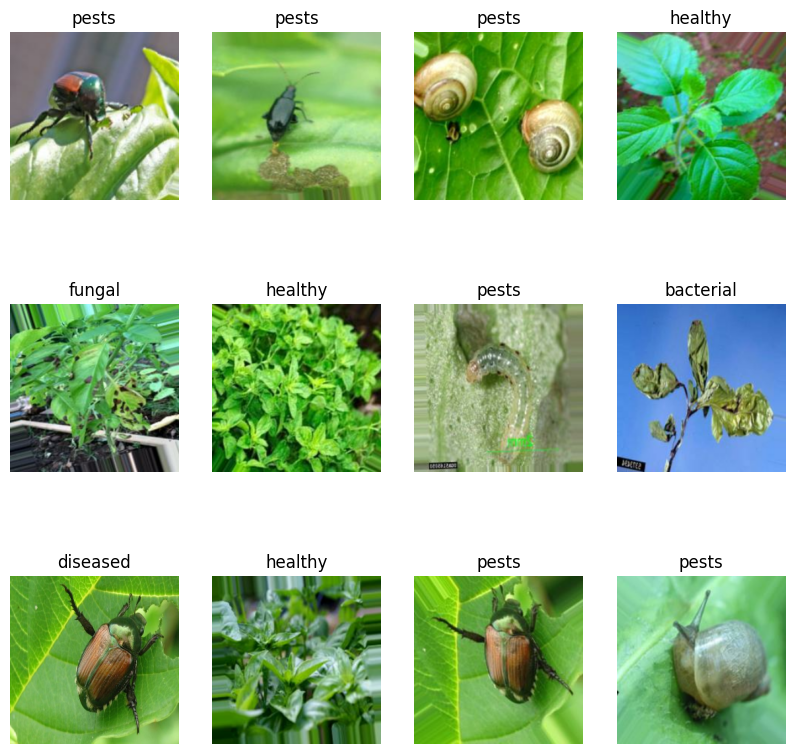

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#pre-processing: data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

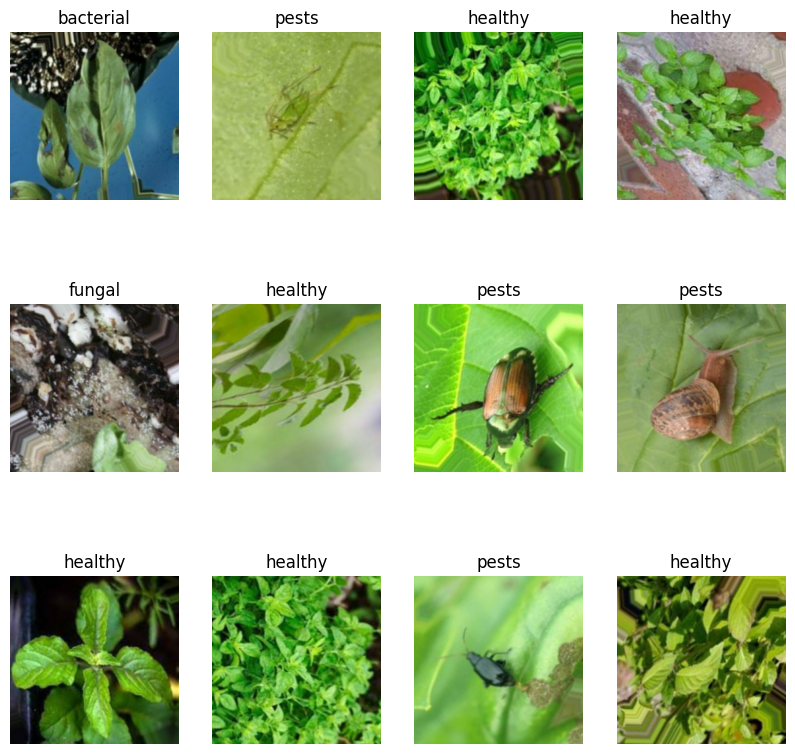

In [ ]:
#disable shuffling to see augmentation result

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#building CNN model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    #feature extraction
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 123008)             

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
59/59 [==============================] - 22s 371ms/step - loss: 0.0786 - accuracy: 0.9807 - val_loss: 0.0645 - val_accuracy: 0.9866
Epoch 2/30
59/59 [==============================] - 21s 343ms/step - loss: 0.0825 - accuracy: 0.9775 - val_loss: 0.0950 - val_accuracy: 0.9777
Epoch 3/30
59/59 [==============================] - 16s 271ms/step - loss: 0.1008 - accuracy: 0.9710 - val_loss: 0.4567 - val_accuracy: 0.8170
Epoch 4/30
59/59 [==============================] - 16s 265ms/step - loss: 0.1694 - accuracy: 0.9576 - val_loss: 0.1039 - val_accuracy: 0.9866
Epoch 5/30
59/59 [==============================] - 15s 262ms/step - loss: 0.1101 - accuracy: 0.9721 - val_loss: 0.0873 - val_accuracy: 0.9821
Epoch 6/30
59/59 [==============================] - 16s 271ms/step - loss: 0.0569 - accuracy: 0.9871 - val_loss: 0.3398 - val_accuracy: 0.8973
Epoch 7/30
59/59 [==============================] - 16s 263ms/step - loss: 0.0998 - accuracy: 0.9785 - val_loss: 0.0784 - val_accuracy: 0.9821

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 23ms/step - loss: 0.1018 - accuracy: 0.9883


In [ ]:
scores2 = model.evaluate(train_ds)

59/59 [==============================] - 15s 246ms/step - loss: 0.0750 - accuracy: 0.9834


In [ ]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 0s 20ms/step - loss: 0.0216 - accuracy: 0.9955


In [ ]:
score4 = model.evaluate(dataset)

74/74 [==============================] - 3s 37ms/step - loss: 0.0496 - accuracy: 0.9885


In [ ]:
scores

[0.10178453475236893, 0.98828125]

In [ ]:
scores2

[0.07496215403079987, 0.9833601713180542]

In [ ]:
scores3

[0.021577822044491768, 0.9955357313156128]

In [ ]:
score4

[0.04956359788775444, 0.9884763360023499]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


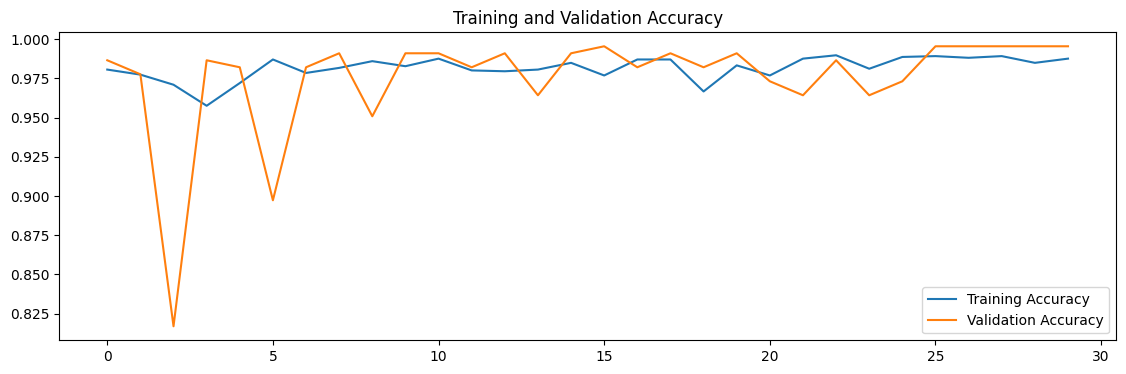

In [ ]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

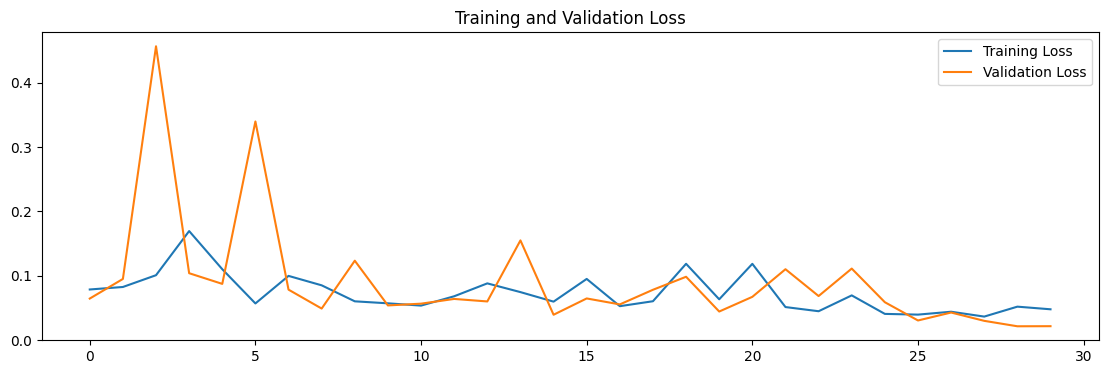

In [ ]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: bacterial
1/1 [==============================] - 0s 393ms/step
predicted label: bacterial


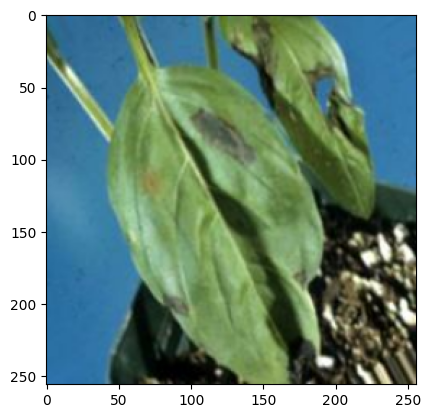

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


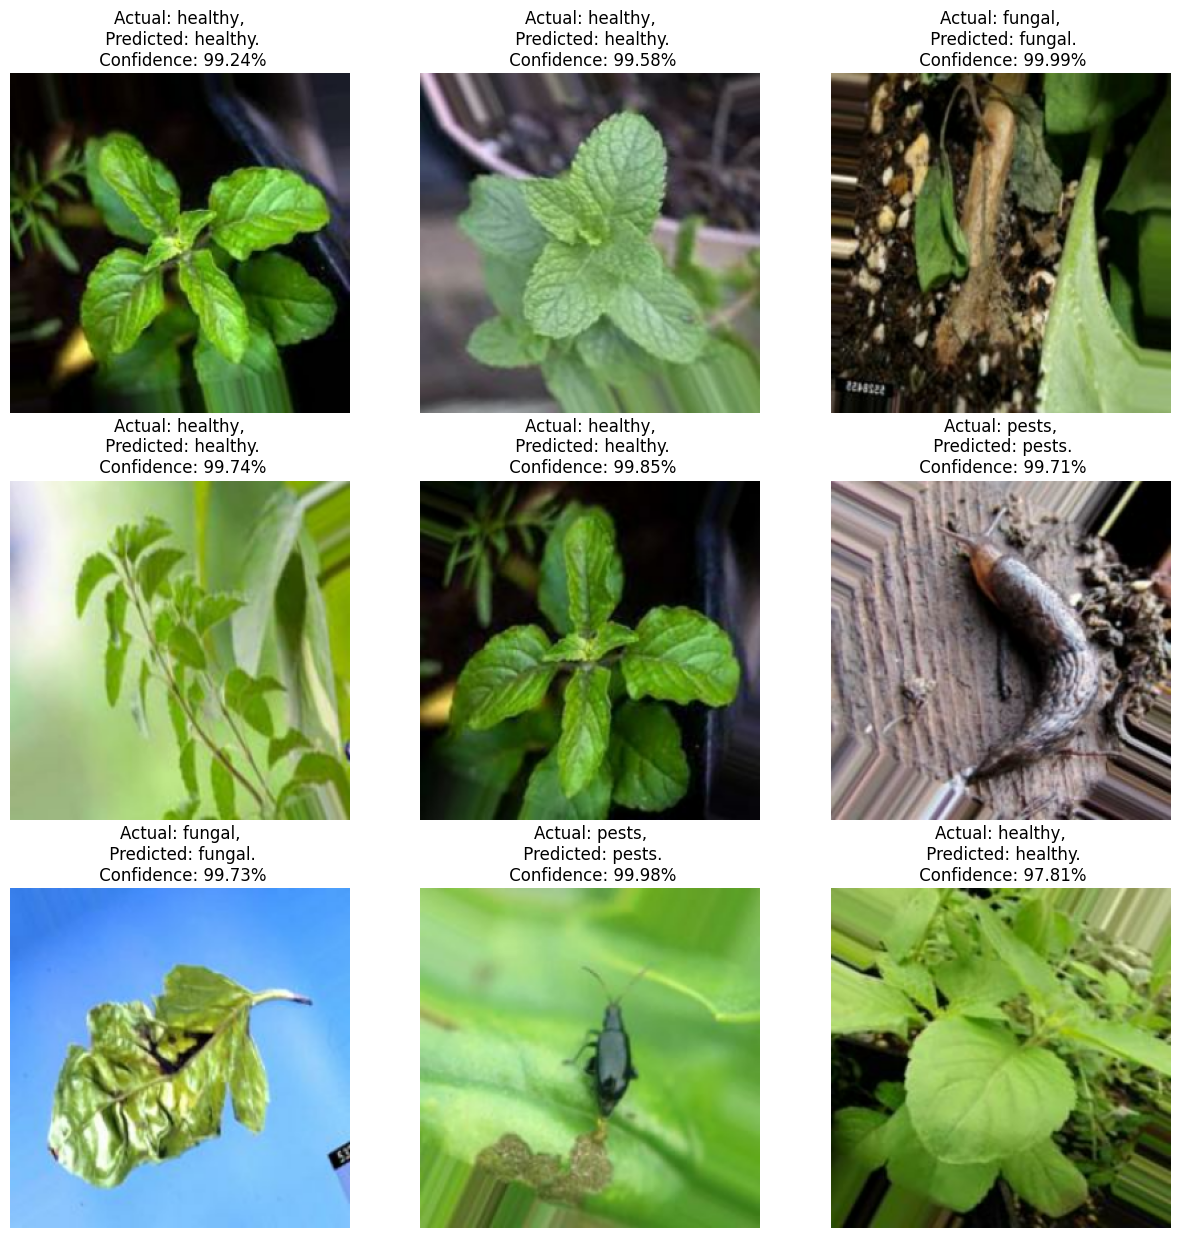

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 0s 19ms/step


In [ ]:
#predicted probability
print(y_pred_prob)

[[9.9963367e-01 7.8900426e-05 2.8702529e-04 ... 9.3945116e-11
  2.3544569e-18 1.7021485e-14]
 [5.8828925e-07 1.5319389e-05 9.9998403e-01 ... 1.4595705e-12
  3.9065863e-20 9.1054931e-13]
 [3.9526725e-22 3.2514633e-09 2.7099281e-18 ... 1.8887159e-22
  4.5495515e-14 9.5957080e-16]
 ...
 [3.5807756e-12 2.0154760e-08 9.8851669e-05 ... 1.2599773e-17
  5.5883892e-17 7.7644526e-17]
 [9.9991989e-01 2.2367129e-05 5.7695517e-05 ... 4.4089350e-11
  9.0883245e-20 7.4052533e-15]
 [4.4380713e-02 1.7943783e-02 3.5125781e-02 ... 6.3747157e-06
  5.8859057e-10 5.6188698e-09]]


In [ ]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [ ]:
#predicted labels
print(y_pred_labels)

[0 2 3 5 5 5 3 5 2 5 5 5 3 2 0 3 5 5 3 5 5 3 5 3 3 3 5 3 3 5 3 2 2 5 5 2 5
 3 3 2 3 3 5 2 5 3 3 2 5 2 5 5 5 5 3 5 5 0 3 5 3 3 2 2 2 3 2 3 2 0 3 5 0 5
 5 0 0 5 5 2 0 2 2 3 3 5 5 2 3 0 3 5 3 5 5 5 3 3 2 3 3 5 2 5 3 3 5 5 0 4 5
 5 2 3 3 5 5 3 3 3 0 3 5 3 5 3 5 3 3 0 3 5 0 5 5 3 0 5 5 3 2 3 3 3 3 2 2 2
 3 5 3 2 3 2 5 5 2 5 3 3 4 0 3 1 2 5 2 5 5 5 2 3 5 3 2 5 0 2 5 2 3 3 3 2 2
 0 0 3 0 2 2 3 2 3 3 3 0 4 2 0 2 2 5 5 5 0 5 2 0 3 3 3 3 2 5 5 2 5 5 5 3 3
 2 5 3 3 2 3 2 5 2 0 3 3 5 3 5 2 2 5 3 5 5 0 5 0 3 3 5 3 2 2 2 5 0 5]


In [ ]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
#true labels
print(y_true_labels)

[0 2 3 5 5 5 3 5 2 5 5 5 3 2 0 3 5 5 3 5 5 3 5 3 3 3 5 3 3 5 3 2 2 3 3 3 0
 4 2 0 2 2 5 5 5 0 5 2 0 3 3 3 3 2 5 5 2 5 5 5 3 3 2 5 3 3 2 3 2 5 2 0 3 3
 5 3 5 2 2 5 3 5 5 0 5 0 3 3 5 3 2 2 2 5 0 5 3 3 2 3 3 5 2 5 3 3 5 5 0 3 5
 5 2 3 3 5 5 3 3 3 0 3 5 3 5 3 5 3 4 0 3 5 0 5 5 3 0 5 5 3 2 3 3 3 3 2 2 2
 3 5 3 2 3 2 5 5 2 5 3 3 2 3 2 3 2 0 3 5 0 5 5 0 0 5 5 2 0 2 2 3 3 5 5 2 3
 0 3 5 3 5 5 5 4 0 3 1 2 5 2 5 5 5 2 3 5 3 2 5 0 2 5 2 3 3 3 2 2 0 0 3 0 2
 2 3 2 5 5 2 5 3 3 2 3 3 5 2 5 3 3 2 5 2 5 5 5 5 3 5 5 0 3 5 3 3 2 2]


In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

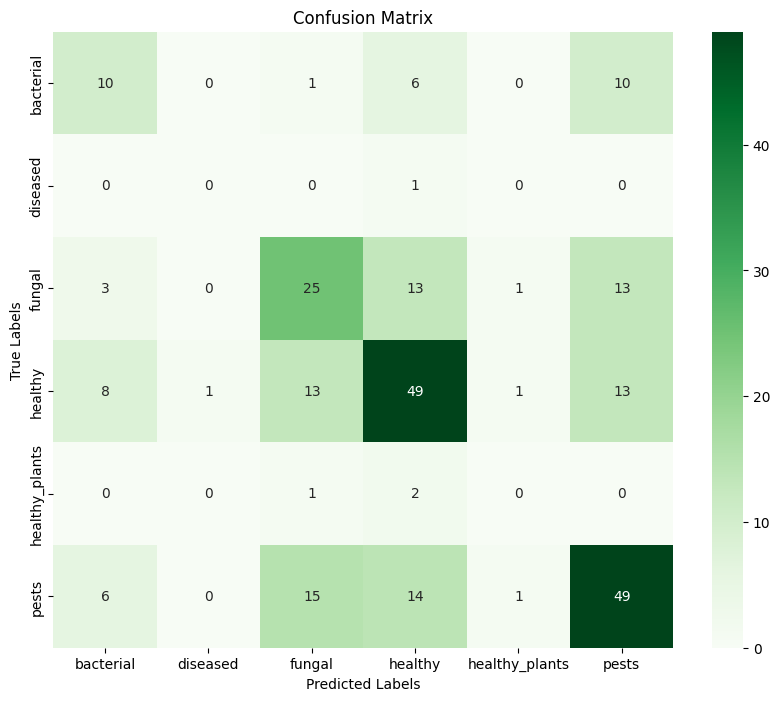

In [ ]:
#disable shuffling dataset before printing confusion matrix

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def calculate_accuracy(confusion_matrix):
    diagonal_sum = np.trace(confusion_matrix)
    total_sum = np.sum(confusion_matrix)
    accuracy = diagonal_sum / total_sum
    return accuracy

accuracy = calculate_accuracy(cm)
print("Accuracy:", accuracy)

Accuracy: 0.51953125


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#accuracy for each class
accuracy_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_per_class.append(accuracy)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {accuracy_per_class[class_index]}")

8/8 [==============================] - 0s 18ms/step
Accuracy for class 'bacterial': 0.8125
Accuracy for class 'diseased': 0.9921875
Accuracy for class 'fungal': 0.65625
Accuracy for class 'healthy': 0.5546875
Accuracy for class 'healthy_plants': 0.9765625
Accuracy for class 'pests': 0.53125


In [ ]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificity = calculate_specificity(cm)
print("Specificity:", specificity)

Specificity: 1.0


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#specificity for each class
specificity_per_class = []
for class_index in range(len(class_names)):
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - cm[class_index, class_index]
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Specificity for class '{class_name}': {specificity_per_class[class_index]}")

8/8 [==============================] - 0s 19ms/step
Specificity for class 'bacterial': 0.9082969432314411
Specificity for class 'diseased': 1.0
Specificity for class 'fungal': 0.8258706467661692
Specificity for class 'healthy': 0.672514619883041
Specificity for class 'healthy_plants': 0.9920948616600791
Specificity for class 'pests': 0.7134502923976608


In [ ]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

sensitivity = calculate_sensitivity(cm)
print("Sensitivity:", sensitivity)

Sensitivity: 1.0


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#sensitivity for each class
sensitivity_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FN = np.sum(cm[class_index, :]) - TP
    P = np.sum(cm[:, class_index])
    sensitivity = TP / (TP + FN)
    sensitivity_per_class.append(sensitivity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Sensitivity for class '{class_name}': {sensitivity_per_class[class_index]}")


8/8 [==============================] - 0s 18ms/step
Sensitivity for class 'bacterial': 0.1111111111111111
Sensitivity for class 'diseased': 0.0
Sensitivity for class 'fungal': 0.23636363636363636
Sensitivity for class 'healthy': 0.3176470588235294
Sensitivity for class 'healthy_plants': 0.0
Sensitivity for class 'pests': 0.32941176470588235


In [ ]:
def calculate_precision(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    precision = true_positives / (true_positives + false_positives)
    return precision

precision = calculate_precision(cm)
print("Precision:", precision)

Precision: nan


<ipython-input-64-c51ecbd17bcc>:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#precision for each class
precision_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    P = np.sum(cm[class_index, :])
    precision = TP / (TP + FP)
    precision_per_class.append(precision)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Precision for class '{class_name}': {precision_per_class[class_index]}")


8/8 [==============================] - 0s 18ms/step
Precision for class 'bacterial': 0.4074074074074074
Precision for class 'diseased': 0.0
Precision for class 'fungal': 0.4
Precision for class 'healthy': 0.4470588235294118
Precision for class 'healthy_plants': 0.0
Precision for class 'pests': 0.5058823529411764


In [ ]:
def calculate_f1_score(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    false_negatives = confusion_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1_score = calculate_f1_score(cm)
print("F1 Score:", f1_score)

F1 Score: nan


<ipython-input-66-b7b494fef618>:6: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)
<ipython-input-66-b7b494fef618>:7: RuntimeWarning: invalid value encountered in scalar divide
  recall = true_positives / (true_positives + false_negatives)


In [ ]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#F1 score for each class
f1_score_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    f1_score_per_class.append(f1_score)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"F1 score for class '{class_name}': {f1_score_per_class[class_index]}")

8/8 [==============================] - 0s 19ms/step
F1 score for class 'bacterial': 0.25925925925925924
F1 score for class 'diseased': nan
F1 score for class 'fungal': 0.2909090909090909
F1 score for class 'healthy': 0.4470588235294118
F1 score for class 'healthy_plants': nan
F1 score for class 'pests': 0.4000000000000001


<ipython-input-67-53840952d5f6>:19: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [ ]:
# data = tf.data.Dataset.from_tensor_slices((images, labels))
for image, labels in test_ds:
    arr = labels.numpy()
    arr_expanded = np.expand_dims(arr, axis=0)
    arr2 = np.concatenate(arr_expanded, axis = 0)
    print(arr2)

[2 5 5 2 5 3 3 2 3 3 5 2 5 3 3 2 5 2 5 5 5 5 3 5 5 0 3 5 3 3 2 2]
[3 3 2 3 2 5 2 0 3 3 5 3 5 2 2 5 3 5 5 0 5 0 3 3 5 3 2 2 2 5 0 5]
[4 0 3 5 0 5 5 3 0 5 5 3 2 3 3 3 3 2 2 2 3 5 3 2 3 2 5 5 2 5 3 3]
[2 3 2 3 2 0 3 5 0 5 5 0 0 5 5 2 0 2 2 3 3 5 5 2 3 0 3 5 3 5 5 5]
[3 3 2 3 3 5 2 5 3 3 5 5 0 3 5 5 2 3 3 5 5 3 3 3 0 3 5 3 5 3 5 3]
[2 3 3 3 0 4 2 0 2 2 5 5 5 0 5 2 0 3 3 3 3 2 5 5 2 5 5 5 3 3 2 5]
[4 0 3 1 2 5 2 5 5 5 2 3 5 3 2 5 0 2 5 2 3 3 3 2 2 0 0 3 0 2 2 3]
[0 2 3 5 5 5 3 5 2 5 5 5 3 2 0 3 5 5 3 5 5 3 5 3 3 3 5 3 3 5 3 2]


In [ ]:
plabel = labels.numpy()
print(plabel)

[0 2 3 5 5 5 3 5 2 5 5 5 3 2 0 3 5 5 3 5 5 3 5 3 3 3 5 3 3 5 3 2]


In [ ]:
predicted_probabilities = model.predict(test_ds)
print(predicted_probabilities)

8/8 [==============================] - 0s 18ms/step
[[2.8246814e-09 5.7988928e-04 1.7920872e-06 ... 4.2304373e-07
  4.5654357e-08 1.9821467e-08]
 [9.9979728e-01 2.0257375e-04 7.4996294e-08 ... 3.4538344e-17
  5.9733743e-28 1.9619138e-20]
 [2.6024509e-06 8.5841835e-05 4.8250938e-03 ... 7.3877200e-06
  9.5106948e-08 3.2239993e-07]
 ...
 [2.5556172e-08 6.5844902e-04 1.6748326e-04 ... 2.7478801e-09
  8.3268887e-12 1.8302584e-10]
 [1.2707142e-14 4.2574527e-05 4.7371936e-06 ... 6.4896463e-21
  1.3995779e-26 4.0200366e-15]
 [1.5181972e-10 5.9652305e-09 1.2774091e-05 ... 1.6697237e-14
  5.4538433e-18 1.8232399e-15]]


In [ ]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)

[4 0 3 1 2 5 2 5 5 5 2 3 5 3 2 5 0 2 5 2 3 3 3 2 2 0 0 3 0 2 2 3 0 2 3 5 5
 5 3 5 2 5 5 5 3 2 0 3 5 5 3 5 5 3 5 3 3 3 5 3 3 5 3 2 3 0 3 5 0 5 5 3 0 5
 5 3 2 3 3 3 3 2 2 2 3 5 3 2 3 2 5 5 2 5 3 3 2 5 5 2 5 3 3 2 3 3 5 2 5 3 3
 2 5 2 5 5 5 5 3 5 5 0 3 5 3 3 2 2 3 3 2 3 2 5 2 0 3 3 5 3 5 2 2 5 3 5 5 0
 5 0 3 3 5 3 2 2 2 5 0 5 2 3 3 3 0 4 2 0 2 2 5 5 5 0 5 2 0 3 3 3 3 2 5 5 2
 5 5 5 3 3 2 5 3 3 2 3 3 5 2 5 3 3 5 5 0 4 5 5 2 3 3 5 5 3 3 3 0 3 5 3 5 3
 5 3 2 3 2 3 2 0 3 5 0 5 5 0 0 5 5 2 0 2 2 3 3 5 5 2 3 0 3 5 3 5 5 5]
